In [294]:
import pandas as pd
import fitz


In [295]:
import fitz
text_list=[]
# Open the PDF file
doc = fitz.open("2016_adidas_sustainability_progress_report.pdf")

# Loop through each page of the PDF file
for page in doc:
    for block in page.get_text("blocks"):
        # Check if block is text
        if block[6] == 0:
            # Extract text and page number
            text_list.append([block[4],page.number+1])
# Close the PDF file
doc.close()

In [296]:
# Convert data to DataFrame
df=pd.DataFrame(text_list,columns=["text","page_number"])
#Remove non-ascii characters
df.text.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [297]:
# If a paragraph starts with a lower case character add it to previous row and delite
n_paragraphs=[0,len(df)]
while n_paragraphs[-1]!=n_paragraphs[-2]:
    i=1
    while i < len(df):
        paragraph_string=str(df.iloc[i][0])
        if paragraph_string[0].islower() == True:
            df.at[i-1,'text']+= " "+paragraph_string
            df=df.drop(i).reset_index(drop=True)
        i+=1
    n_paragraphs.append(len(df))

In [298]:
#Delete paragraphs with len >50
df=df[df['text'].map(len) > 50]

In [299]:
#Table detecton
#Count new pages - occurances of \n
df['newpage_count'] = df.apply(lambda x: x["text"].count("\n"), axis=1)
#The frequency of new pages - occurances of \n divided by len of the string
df['newpage_frequency'] = df.apply(lambda x: x["newpage_count"]/ len(x['text']), axis=1)

<AxesSubplot:>

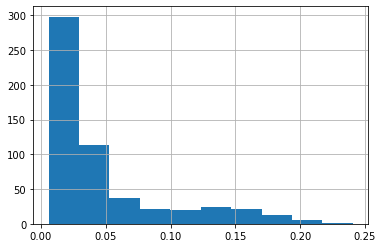

In [300]:
df.newpage_frequency.hist()

In [301]:
# Drop rows where the new page frequency is over 0.1. With larger numbers we could get more tables but lose some narrow paragraphs
df_clean=df[df['newpage_frequency'] < 0.1]
# Drop unnecessary columns
df_clean=df_clean.drop(columns=['newpage_count', 'newpage_frequency'])
df_clean=df_clean.reset_index(drop=True)

In [305]:
# Write data to csv file
df_clean.to_csv("2016_adidas_clean.csv",index=False)